In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
data_folder = '../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Shape of regular image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)



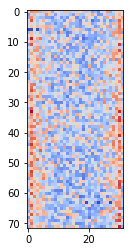

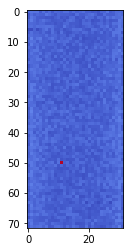

In [3]:
input_images=data_sample[:]
hotregion_image=[]


for k in input_images:
    a=np.random.randint(input_images.shape[2]-1)
    b=np.random.randint(input_images.shape[1]-1)
    xdim=(a,a+1)
    ydim=(b,b+1)
    hotregion_image.append( u.hotregion(k,xdim,ydim))

hotregion_image=np.array(hotregion_image)

print "Shape of regular image is: ",input_images.shape

print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.show()
plt.clf()


im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


If you want to see the group of images

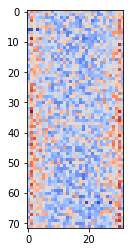

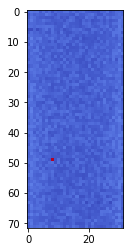

-----------------


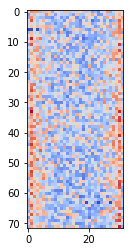

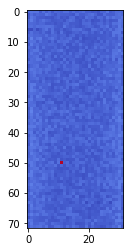

-----------------


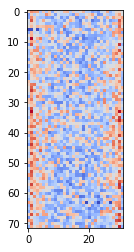

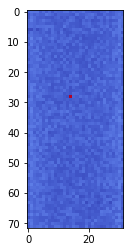

-----------------


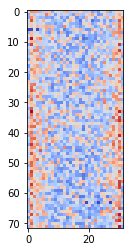

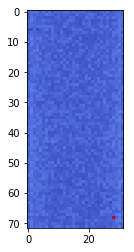

-----------------


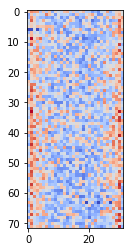

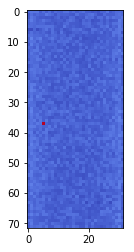

-----------------


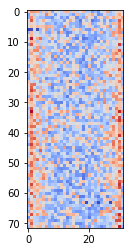

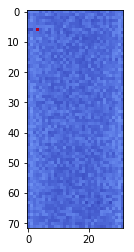

-----------------


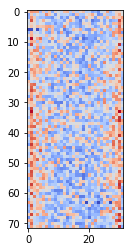

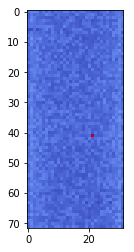

-----------------


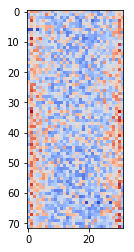

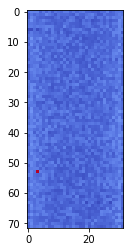

-----------------


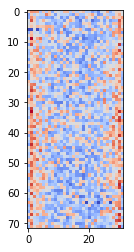

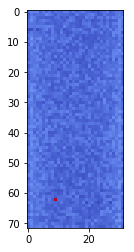

-----------------


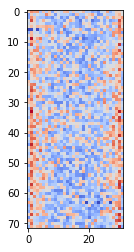

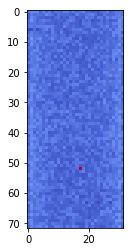

-----------------


In [4]:
for k in range(10):
    im=plt.imshow(input_images[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()

  
    im=plt.imshow(hotregion_image[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
             #as opposed to plt.close which closes the window. If you are showing many images at a time without
             #closing the window it is better.
    print '-----------------'


In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)

print sample.shape

(1998, 72, 32)



For CNN

create the corresponding label matrices


In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))


In [7]:
#this is if I want a binary classification
y[999:]=1

#since this is a binary situation you can have the labels as a interger or a vector
#if you want it as intergers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,2)

In [8]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (1998, 72, 32)
y shape is:  (1998, 2)


Xtrain.shape (1198, 72, 32)
Xtest.shape (800, 72, 32)
ytrain.shape (1198, 2)
ytest.shape (800, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


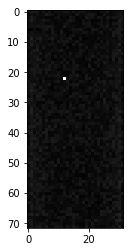

-------------------
[ 0.  1.]


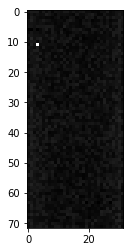

-------------------
[ 1.  0.]


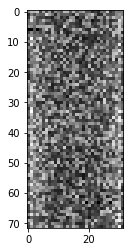

-------------------
[ 1.  0.]


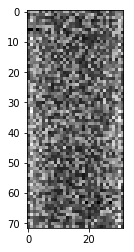

-------------------
[ 0.  1.]


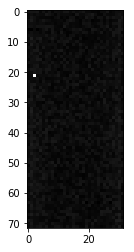

-------------------
[ 1.  0.]


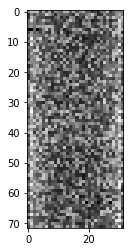

-------------------
[ 0.  1.]


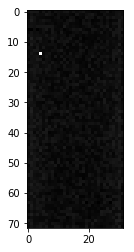

-------------------
[ 0.  1.]


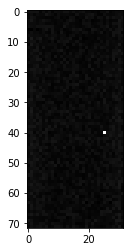

-------------------
[ 0.  1.]


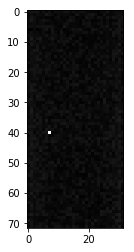

-------------------
[ 1.  0.]


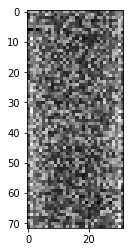

Xtrain.shape after if statement (1198, 72, 32, 1)
Xtest.shape after if statement (800, 72, 32, 1)
ytrain.shape after if statement (1198, 2)
ytest.shape after if statement (800, 2)


In [9]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.gray)
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    


# Creating and training the model

In [13]:
# this is the dummy model
model = Sequential([
BatchNormalization(input_shape=input_shape),
Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'),

Dropout(0.25),

Flatten(),

Dense(2, activation='softmax')

])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',#Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 72, 32, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 15, 8)         80        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 7, 8)          584       
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 7, 8)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 952)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1906      
Total params: 2,574
Trainable params: 2,572
Non-trainable params: 2
_________________________________________________________________


In [14]:
checkpointer = ModelCheckpoint(filepath='supervised_good_and_hot_model.hdf5', verbose=4, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=4, mode='auto')

history = model.fit(Xtrain,ytrain,epochs=250
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer])#,earlystop])

Train on 1198 samples, validate on 800 samples
Epoch 1/250
Epoch 00001: val_loss improved from inf to 0.94694, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.6963 - acc: 0.5326 - val_loss: 0.9469 - val_acc: 0.5000
Epoch 2/250
Epoch 00002: val_loss improved from 0.94694 to 0.91819, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.6663 - acc: 0.5876 - val_loss: 0.9182 - val_acc: 0.4975
Epoch 3/250
Epoch 00003: val_loss improved from 0.91819 to 0.66030, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.6213 - acc: 0.6995 - val_loss: 0.6603 - val_acc: 0.5912
Epoch 4/250
Epoch 00004: val_loss improved from 0.66030 to 0.53802, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.5607 - acc: 0.7796 - val_loss: 0.5380 - val_acc: 0.7887
Epoch 5/250
Epoch 00005: val_loss did not improve
 - 0s - loss: 0.4962 - acc: 0.8180 - val_loss: 0.5560 - val_acc: 0.7250
Epoch 6/250
Epoch 00006: val_loss improved from 0.53802 to 0.40738, sav

Epoch 50/250
Epoch 00050: val_loss did not improve
 - 0s - loss: 0.0364 - acc: 0.9908 - val_loss: 0.0656 - val_acc: 0.9838
Epoch 51/250
Epoch 00051: val_loss did not improve
 - 0s - loss: 0.0205 - acc: 0.9950 - val_loss: 0.0730 - val_acc: 0.9825
Epoch 52/250
Epoch 00052: val_loss improved from 0.05537 to 0.05459, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.0406 - acc: 0.9900 - val_loss: 0.0546 - val_acc: 0.9862
Epoch 53/250
Epoch 00053: val_loss did not improve
 - 0s - loss: 0.0156 - acc: 0.9967 - val_loss: 0.0659 - val_acc: 0.9850
Epoch 54/250
Epoch 00054: val_loss did not improve
 - 0s - loss: 0.0314 - acc: 0.9933 - val_loss: 0.0609 - val_acc: 0.9862
Epoch 55/250
Epoch 00055: val_loss did not improve
 - 0s - loss: 0.0285 - acc: 0.9950 - val_loss: 0.0632 - val_acc: 0.9850
Epoch 56/250
Epoch 00056: val_loss did not improve
 - 1s - loss: 0.0321 - acc: 0.9942 - val_loss: 0.0587 - val_acc: 0.9862
Epoch 57/250
Epoch 00057: val_loss did not improve
 - 0s - loss: 0.020

Epoch 115/250
Epoch 00115: val_loss improved from 0.05019 to 0.04821, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.0321 - acc: 0.9933 - val_loss: 0.0482 - val_acc: 0.9938
Epoch 116/250
Epoch 00116: val_loss did not improve
 - 1s - loss: 0.0269 - acc: 0.9950 - val_loss: 0.0588 - val_acc: 0.9912
Epoch 117/250
Epoch 00117: val_loss did not improve
 - 0s - loss: 0.0085 - acc: 0.9983 - val_loss: 0.0637 - val_acc: 0.9900
Epoch 118/250
Epoch 00118: val_loss did not improve
 - 0s - loss: 0.0058 - acc: 0.9992 - val_loss: 0.0647 - val_acc: 0.9888
Epoch 119/250
Epoch 00119: val_loss did not improve
 - 0s - loss: 0.0092 - acc: 0.9983 - val_loss: 0.0624 - val_acc: 0.9888
Epoch 120/250
Epoch 00120: val_loss did not improve
 - 0s - loss: 0.0063 - acc: 0.9975 - val_loss: 0.0562 - val_acc: 0.9900
Epoch 121/250
Epoch 00121: val_loss did not improve
 - 1s - loss: 0.0152 - acc: 0.9967 - val_loss: 0.0649 - val_acc: 0.9900
Epoch 122/250
Epoch 00122: val_loss did not improve
 - 1s - los

Epoch 175/250
Epoch 00175: val_loss did not improve
 - 0s - loss: 0.0172 - acc: 0.9975 - val_loss: 0.0256 - val_acc: 0.9950
Epoch 176/250
Epoch 00176: val_loss improved from 0.02544 to 0.02182, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.0133 - acc: 0.9975 - val_loss: 0.0218 - val_acc: 0.9950
Epoch 177/250
Epoch 00177: val_loss did not improve
 - 0s - loss: 0.0035 - acc: 0.9992 - val_loss: 0.0306 - val_acc: 0.9925
Epoch 178/250
Epoch 00178: val_loss improved from 0.02182 to 0.02054, saving model to supervised_good_and_hot_model.hdf5
 - 1s - loss: 0.0165 - acc: 0.9975 - val_loss: 0.0205 - val_acc: 0.9962
Epoch 179/250
Epoch 00179: val_loss did not improve
 - 0s - loss: 0.0118 - acc: 0.9983 - val_loss: 0.0207 - val_acc: 0.9962
Epoch 180/250
Epoch 00180: val_loss did not improve
 - 0s - loss: 0.0097 - acc: 0.9983 - val_loss: 0.0288 - val_acc: 0.9925
Epoch 181/250
Epoch 00181: val_loss did not improve
 - 0s - loss: 0.0072 - acc: 0.9992 - val_loss: 0.0252 - val_acc: 0

Epoch 240/250
Epoch 00240: val_loss did not improve
 - 1s - loss: 0.0116 - acc: 0.9975 - val_loss: 0.0238 - val_acc: 0.9962
Epoch 241/250
Epoch 00241: val_loss did not improve
 - 1s - loss: 0.0150 - acc: 0.9975 - val_loss: 0.0261 - val_acc: 0.9962
Epoch 242/250
Epoch 00242: val_loss did not improve
 - 1s - loss: 0.0149 - acc: 0.9967 - val_loss: 0.0218 - val_acc: 0.9962
Epoch 243/250
Epoch 00243: val_loss did not improve
 - 1s - loss: 0.0113 - acc: 0.9983 - val_loss: 0.0245 - val_acc: 0.9962
Epoch 244/250
Epoch 00244: val_loss did not improve
 - 1s - loss: 0.0115 - acc: 0.9967 - val_loss: 0.0229 - val_acc: 0.9962
Epoch 245/250
Epoch 00245: val_loss did not improve
 - 1s - loss: 0.0109 - acc: 0.9983 - val_loss: 0.0270 - val_acc: 0.9962
Epoch 246/250
Epoch 00246: val_loss did not improve
 - 1s - loss: 0.0060 - acc: 0.9992 - val_loss: 0.0273 - val_acc: 0.9950
Epoch 247/250
Epoch 00247: val_loss did not improve
 - 1s - loss: 0.0220 - acc: 0.9958 - val_loss: 0.0222 - val_acc: 0.9962
Epoch 24

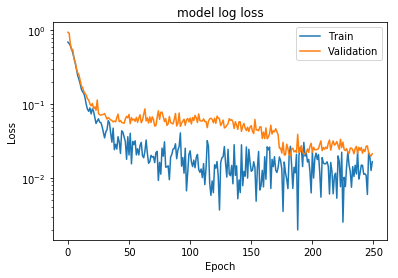

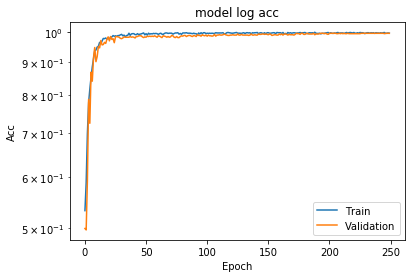

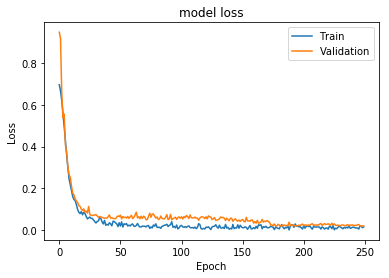

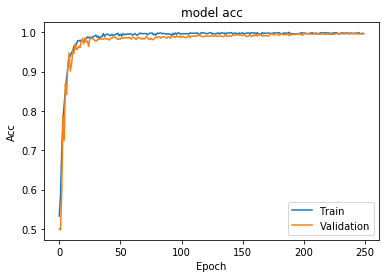

In [15]:
u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")



In [16]:
best_model= load_model('supervised_good_and_hot_model.hdf5')

In [17]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [18]:
np.all(ypredproba==ypred)
#this confirms my suspicions

True

In [19]:
print ytestclass[40:50],'\n\n\n', ypredclass[40:50]

[[0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]] 


[[0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]]


Confusion matrix, without normalization
[[402   0]
 [  3 395]]


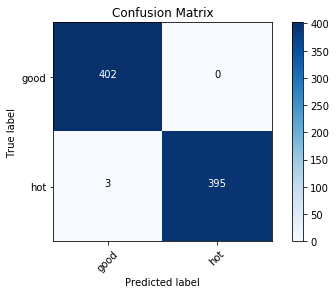

In [20]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
#print metrics.accuracy_score(ytest,ypred)
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','hot']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')

# Now I'm going to recreate this model using the SKlearn API wrapper from Keras

0.998737468437 For the label #0


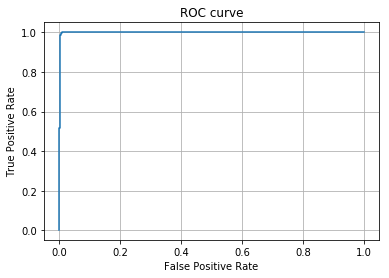

In [21]:
fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,0],pos_label=0)
roc_auc = auc(fpr, tpr)
print roc_auc,'For the label #0'

plt.plot(fpr,tpr)#, color='green', linestyle='dashed',markerfacecolor='blue',marker='o' )#)markersize=12
   
#plt.xlim([-.1,1.5])
   
#plt.ylim([-0.1,1.5])    
   
plt.title('ROC curve')
   
plt.ylabel('True Positive Rate')
   
plt.xlabel('False Positive Rate')
   
#plt.legend()
   
plt.grid(True)


In [22]:
fpr

array([ 0.        ,  0.        ,  0.00251256,  0.00251256,  0.00502513,
        0.00502513,  0.00753769,  0.00753769,  1.        ])